In [ ]:
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import matplotlib
matplotlib.style.use('ggplot')

# Model


In [ ]:
print(tf.__version__)

2.7.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
IMAGE_SHAPE = (224, 224)
TRAINING_DATA_DIR = 'drive/MyDrive/images_pollution' #path to dataset



In [ ]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1
    # zoom_range=.2,
    # horizontal_flip=True,
    # rotation_range=30,
    # shear_range = 10,
    # width_shift_range=.2,
    # height_shift_range=.2
)
train_generator = datagen.flow_from_directory(
    TRAINING_DATA_DIR,
    shuffle=True,
    target_size=IMAGE_SHAPE,
    
)
valid_generator=datagen.flow_from_directory(TRAINING_DATA_DIR,target_size=(224,224),subset='validation',batch_size = 32)

# test_generator = datagen.flow_from_directory(
#     VALID_DATA_DIR,
#     shuffle=False,
#     target_size=IMAGE_SHAPE,
#     batch_size = 1
# )

Found 197 images belonging to 2 classes.
Found 19 images belonging to 2 classes.


In [ ]:
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet import ResNet152
from keras.applications.resnet import ResNet50
from keras.applications.densenet import DenseNet121
from keras.applications.densenet import DenseNet169
model = DenseNet169(include_top = False,input_shape=(224,224,3),weights = 'imagenet')
model.trainable = False
print(model.layers[0].output.shape)
# def build_model(num_classes, model):
#     conv1 = tf.keras.layers.Conv2D(1024,3,1,'valid',activation='relu')(model.layers[-1].output)
#     conv2 = tf.keras.layers.Conv2D(512,2,1,'valid',activation='relu')(conv1)
#     gmax = tf.keras.layers.GlobalMaxPooling2D()(conv2)
#     # gmax = tf.keras.layers.GlobalMaxPooling2D()(model.layers[-1].output)
#     flat1 = Flatten()(gmax)
#     input_1 = model.layers[0].output
#     conv1 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', 
#                            input_shape=(224, 224, 3))(input_1)
#     maxp1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2)(conv1)
#     conv2 = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(maxp1)
#     maxp2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2)(conv2)
#     conv3 = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(maxp2)
#     maxp3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2)(conv3)
#     flat2 = tf.keras.layers.Flatten()(maxp3)
#     concat = tf.keras.layers.Concatenate()([flat2, flat1])
#     d1 = tf.keras.layers.Dense(64, activation='relu')(concat)
#     output = tf.keras.layers.Dense(num_classes, activation='softmax')(d1)
#     model1 = Model(inputs = [model.inputs], outputs = [output] )
#     return model1
# model = build_model(num_classes=20, model = model)

conv1 = tf.keras.layers.Conv2D(1024,3,1,'valid',activation='relu')(model.layers[-1].output)
conv2 = tf.keras.layers.Conv2D(512,2,1,'valid',activation='relu')(conv1)
gmax = tf.keras.layers.GlobalMaxPooling2D()(conv2)
# gmax = tf.keras.layers.GlobalMaxPooling2D()(model.layers[-1].output)
flat1 = Flatten()(gmax)
class1 = Dense(512, activation='relu')(flat1)
output = Dense(2, activation='softmax')(class1)
model = Model(inputs=model.inputs, outputs=output)
model.summary()

In [ ]:
model.compile(
          loss      = tf.keras.losses.CategoricalCrossentropy(),
          metrics   = tf.keras.metrics.CategoricalAccuracy(),
          optimizer = tf.keras.optimizers.Adam())
# fit 
model.fit(train_generator,validation_data=valid_generator ,epochs=3)

Epoch 1/3
7/7 [==============================] - 55s 7s/step - loss: 2.8123 - categorical_accuracy: 0.6193 - val_loss: 0.9618 - val_categorical_accuracy: 0.6316
Epoch 2/3
7/7 [==============================] - 43s 6s/step - loss: 0.4956 - categorical_accuracy: 0.9036 - val_loss: 0.7998 - val_categorical_accuracy: 0.7895
Epoch 3/3
7/7 [==============================] - 45s 6s/step - loss: 0.0684 - categorical_accuracy: 0.9848 - val_loss: 0.0463 - val_categorical_accuracy: 0.9474


In [ ]:
model.save('drive/MyDrive/AirView_final/pollution.h5')

NameError: ignored

In [ ]:
import tensorflow as tf
model = tf.keras.models.load_model('drive/MyDrive/AirView_final/pollution.h5')

In [ ]:
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
import cv2

class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        # store the model, the class index used to measure the class
        # activation map, and the layer to be used when visualizing
        # the class activation map
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        # if the layer name is None, attempt to automatically find
        # the target output layer
        if self.layerName is None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        # attempt to find the final convolutional layer in the network
        # by looping over the layers of the network in reverse order
        for layer in reversed(self.model.layers):
            # check to see if the layer has a 4D output
            if len(layer.output_shape) == 4:
                return layer.name
        # otherwise, we could not find a 4D layer so the GradCAM
        # algorithm cannot be applied
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")


    def compute_heatmap(self, image, eps=1e-8):
        # construct our gradient model by supplying (1) the inputs
        # to our pre-trained model, (2) the output of the (presumably)
        # final 4D layer in the network, and (3) the output of the
        # softmax activations from the model
        gradModel = Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output, self.model.output])

        # record operations for automatic differentiation
        with tf.GradientTape() as tape:
            # cast the image tensor to a float-32 data type, pass the
            # image through the gradient model, and grab the loss
            # associated with the specific class index
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            
            loss = predictions[:, tf.argmax(predictions[0])]
    
        # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)

        # compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = 7 > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads
        # the convolution and guided gradients have a batch dimension
        # (which we don't need) so let's grab the volume itself and
        # discard the batch
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]

        # compute the average of the gradient values, and using them
        # as weights, compute the ponderation of the filters with
        # respect to the weights
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

        # grab the spatial dimensions of the input image and resize
        # the output class activation map to match the input image
        # dimensions
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))
        # normalize the heatmap such that all values lie in the range
        # [0, 1], scale the resulting values to the range [0, 255],
        # and then convert to an unsigned 8-bit integer
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")
        # return the resulting heatmap to the calling function
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5,
                        colormap=cv2.COLORMAP_VIRIDIS):
        # apply the supplied color map to the heatmap and then
        # overlay the heatmap on the input image
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
        # return a 2-tuple of the color mapped heatmap and the output,
        # overlaid image
        return (heatmap, output)

In [ ]:
path = 'drive/MyDrive/images_pollution/pollution_images/pol18.jpg'
image = cv2.imread(path)
# print(image.shape)
image = cv2.resize(image, (224, 224))
image = image.astype('float32') / 255
image = np.expand_dims(image, axis=0)

preds = model.predict(image) 
i = np.argmax(preds[0])

In [ ]:
icam = GradCAM(model, i, 'conv2d') 
heatmap = icam.compute_heatmap(image)
heatmap = cv2.resize(heatmap, (224, 224))

image = cv2.imread(path)
image = cv2.resize(image, (224, 224))
print(heatmap.shape, image.shape)
print(type(heatmap), type(image))

(heatmap, output) = icam.overlay_heatmap(heatmap, image, alpha=0.5)

(224, 224) (224, 224, 3)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


Text(0.5, 1.0, 'Third')

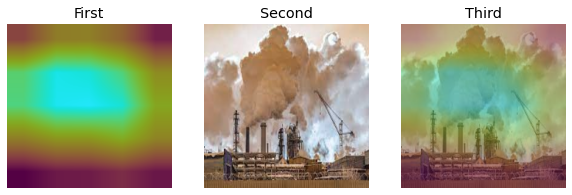

In [ ]:
# code for displaying multiple images in one figure

#import libraries
import cv2
from matplotlib import pyplot as plt

# create figure
fig = plt.figure(figsize=(10, 7))

# setting values to rows and column variables
rows = 2
columns = 3

# reading images
Image1 = heatmap
Image2 = image
Image3 = output


# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)

# showing image
plt.imshow(Image1)
plt.axis('off')
plt.title("First")

# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)

# showing image
plt.imshow(Image2)
plt.axis('off')
plt.title("Second")

# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 3)

# showing image
plt.imshow(Image3)
plt.axis('off')
plt.title("Third")




# Model 2

In [ ]:
import cv2 
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np

In [ ]:
model = tf.keras.models.load_model("drive/MyDrive/AirView_final/pollution.h5")

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

In [ ]:
class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        # store the model, the class index used to measure the class
        # activation map, and the layer to be used when visualizing
        # the class activation map
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        # if the layer name is None, attempt to automatically find
        # the target output layer
        if self.layerName is None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        # attempt to find the final convolutional layer in the network
        # by looping over the layers of the network in reverse order
        for layer in reversed(self.model.layers):
            # check to see if the layer has a 4D output
            if len(layer.output_shape) == 4:
                return layer.name
        # otherwise, we could not find a 4D layer so the GradCAM
        # algorithm cannot be applied
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")


    def compute_heatmap(self, image, eps=1e-8):
        # construct our gradient model by supplying (1) the inputs
        # to our pre-trained model, (2) the output of the (presumably)
        # final 4D layer in the network, and (3) the output of the
        # softmax activations from the model
        gradModel = Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output, self.model.output])

        # record operations for automatic differentiation
        with tf.GradientTape() as tape:
            # cast the image tensor to a float-32 data type, pass the
            # image through the gradient model, and grab the loss
            # associated with the specific class index
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            
            loss = predictions[:, tf.argmax(predictions[0])]
    
        # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)

        # compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads
        # the convolution and guided gradients have a batch dimension
        # (which we don't need) so let's grab the volume itself and
        # discard the batch
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]

        # compute the average of the gradient values, and using them
        # as weights, compute the ponderation of the filters with
        # respect to the weights
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

        # grab the spatial dimensions of the input image and resize
        # the output class activation map to match the input image
        # dimensions
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))
        # normalize the heatmap such that all values lie in the range
        # [0, 1], scale the resulting values to the range [0, 255],
        # and then convert to an unsigned 8-bit integer
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")
        # return the resulting heatmap to the calling function
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5,
                        colormap=cv2.COLORMAP_VIRIDIS):
        # apply the supplied color map to the heatmap and then
        # overlay the heatmap on the input image
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
        # return a 2-tuple of the color mapped heatmap and the output,
        # overlaid image
        return (heatmap, output)

In [ ]:
path = 'drive/MyDrive/images_pollution/pollution_images/pol09.jpg'
image = cv2.imread(path)
# print(image.shape)
image = cv2.resize(image, (224, 224))
image = image.astype('float32') / 255
image = np.expand_dims(image, axis=0)

preds = model.predict(image) 
i = np.argmax(preds[0])

In [ ]:
icam = GradCAM(model, i, 'conv2d') 
heatmap = icam.compute_heatmap(image)
heatmap = cv2.resize(heatmap, (224, 224))

image = cv2.imread(path)
image = cv2.resize(image, (224, 224))
print(heatmap.shape, image.shape)

(heatmap, output) = icam.overlay_heatmap(heatmap, image, alpha=0.5)

(224, 224) (224, 224, 3)


Text(0.5, 1.0, 'Third')

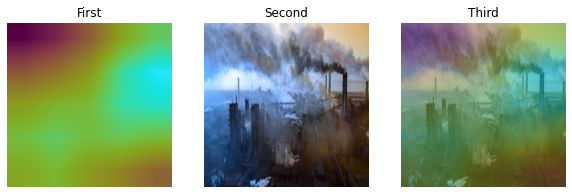

In [ ]:
# code for displaying multiple images in one figure

#import libraries
import cv2
from matplotlib import pyplot as plt

# create figure
fig = plt.figure(figsize=(10, 7))

# setting values to rows and column variables
rows = 2
columns = 3

# reading images
Image1 = heatmap
Image2 = image
Image3 = output


# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)

# showing image
plt.imshow(Image1)
plt.axis('off')
plt.title("First")

# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)

# showing image
plt.imshow(Image2)
plt.axis('off')
plt.title("Second")

# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 3)

# showing image
plt.imshow(Image3)
plt.axis('off')
plt.title("Third")




In [ ]:
import numpy as np
import cv2 as cv
cap = cv.VideoCapture('drive/MyDrive/AirView_final/real_pol.mp4')
# Define the codec and create VideoWriter object
fourcc = cv.VideoWriter_fourcc(*'MP4V')
out = cv.VideoWriter('output.mp4', fourcc, 30.0, (224,  224))
out2 = cv.VideoWriter('output2.mp4', fourcc, 30.0, (224,  224))
cnt = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret :
        print("Can't receive frame (stream end?). Exiting ...")
        break
   
    image = cv2.resize(frame, (224, 224))
    image = image.astype('float32') / 255
    image = np.expand_dims(image, axis=0)
    preds = model.predict(image) 
    i = np.argmax(preds[0])
    icam = GradCAM(model, i, 'conv2d') 
    heatmap = icam.compute_heatmap(image)
    heatmap = cv2.resize(heatmap, (224, 224))

    image = cv2.resize(frame, (224, 224))
    print(heatmap.shape, image.shape, cnt)

    (heatmap, output) = icam.overlay_heatmap(heatmap, image, alpha=0.5)

    
    
    out.write(output)
    out2.write(heatmap)
    cnt = cnt + 1
    # cv.imshow('frame', frame)
    if cv.waitKey(1) == ord('q'):
        break
# Release everything if job is finished
cap.release()
out.release()
cv.destroyAllWindows()

(224, 224) (224, 224, 3) 0
(224, 224) (224, 224, 3) 1
(224, 224) (224, 224, 3) 2
(224, 224) (224, 224, 3) 3
(224, 224) (224, 224, 3) 4
(224, 224) (224, 224, 3) 5
(224, 224) (224, 224, 3) 6
(224, 224) (224, 224, 3) 7
(224, 224) (224, 224, 3) 8
(224, 224) (224, 224, 3) 9
(224, 224) (224, 224, 3) 10
(224, 224) (224, 224, 3) 11
(224, 224) (224, 224, 3) 12
(224, 224) (224, 224, 3) 13
(224, 224) (224, 224, 3) 14
(224, 224) (224, 224, 3) 15
(224, 224) (224, 224, 3) 16
(224, 224) (224, 224, 3) 17
(224, 224) (224, 224, 3) 18
(224, 224) (224, 224, 3) 19
(224, 224) (224, 224, 3) 20
(224, 224) (224, 224, 3) 21
(224, 224) (224, 224, 3) 22
(224, 224) (224, 224, 3) 23
(224, 224) (224, 224, 3) 24
(224, 224) (224, 224, 3) 25
(224, 224) (224, 224, 3) 26
(224, 224) (224, 224, 3) 27
(224, 224) (224, 224, 3) 28
(224, 224) (224, 224, 3) 29
(224, 224) (224, 224, 3) 30
(224, 224) (224, 224, 3) 31
(224, 224) (224, 224, 3) 32
(224, 224) (224, 224, 3) 33
(224, 224) (224, 224, 3) 34
(224, 224) (224, 224, 3) 35
(2